### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
# Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

--2024-04-22 19:09:29--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2024-04-22 19:09:29--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc46a0716e4796b5b8fd60fd968a.dl.dropboxusercontent.com/cd/0/get/CRimQhvmMkO-KKCfgklerUQUS5gSIIPrX9p-bvZ7a5RojM2a_aNUcQ1VK46AdxpoFX9q0MfHp9EdY0JiuYWcYTkDf31Vo_MdhPcTi8t1yGKs3H_KxylgA4mzSt-hXd5Ex2U/file?dl=1# [following]
--2024-04-22 19:09:30--  https://uc46a0716e4796b5b8fd60fd968a.dl.dropboxusercontent.com/cd/0/get/CRimQhvmMkO-KKCfgklerUQUS5gSIIPrX9p-bvZ7a5RojM2a_aNUcQ1VK46AdxpoFX9q0MfHp9EdY0JiuYWcYTkDf31Vo_

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [ ]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

In [ ]:
data.head(2)

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016


In [ ]:
for word in lines:
  print(word)
  break

 Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-



Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [ ]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set(''.join(lines))
tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [ ]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {}
for id, char in enumerate(tokens):
  if char not in token_to_id:
    token_to_id[char] = id

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`.

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [ ]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [ ]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64, window_size=5):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}

        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.pad = nn.ZeroPad2d((window_size - 1, 0, 0, 0))
        self.conv = nn.Conv1d(emb_size, hid_size, kernel_size=window_size, stride=1, padding=0)
        self.linear = nn.Linear(hid_size, n_tokens)
        #END OF YOUR CODE

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # YOUR CODE - apply layers, see docstring above
        embeddings = self.emb(input_ix)
        embeddings = embeddings.permute(0, 2, 1)
        pad_embeddings = self.pad(embeddings)
        conv_out = self.conv(pad_embeddings)
        conv_out = conv_out.permute(0, 2, 1)
        logits = self.linear(conv_out)
        return logits # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
            # print(f'PROBS: {probs}')
            # print(f'prefix_ix: {prefix_ix[0, -1]}')
        return dict(zip(tokens, probs))


In [ ]:
dummy_model = FixedWindowLanguageModel().to(device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines)).to(device)
dummy_logits = dummy_model(dummy_input_ix)
print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv.weight', 'conv.bias', 'linear.weight', 'linear.bias')


In [ ]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [ ]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines])).to(device)
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [ ]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.cpu().numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [ ]:
dummy_model(dummy_input_ix[:, :-1])

tensor([[[-0.2596, -0.0948,  0.2068,  ..., -0.0456, -0.0409,  0.0972],
         [-0.0352, -0.1967, -0.1623,  ..., -0.3264, -0.0308, -0.0519],
         [ 0.3372, -0.3670,  0.0487,  ..., -0.2271, -0.0335,  0.3937],
         ...,
         [-0.1310, -0.0173, -0.4638,  ..., -0.2083,  0.1602, -0.2989],
         [-0.1310, -0.0173, -0.4638,  ..., -0.2083,  0.1602, -0.2989],
         [-0.1310, -0.0173, -0.4638,  ..., -0.2083,  0.1602, -0.2989]],

        [[-0.2596, -0.0948,  0.2068,  ..., -0.0456, -0.0409,  0.0972],
         [-0.0352, -0.1967, -0.1623,  ..., -0.3264, -0.0308, -0.0519],
         [ 0.3372, -0.3670,  0.0487,  ..., -0.2271, -0.0335,  0.3937],
         ...,
         [ 0.0246,  0.1617, -0.2993,  ...,  0.0176,  0.2770, -0.0104],
         [-0.1310, -0.0173, -0.4638,  ..., -0.2083,  0.1602, -0.2989],
         [-0.1310, -0.0173, -0.4638,  ..., -0.2083,  0.1602, -0.2989]],

        [[-0.2596, -0.0948,  0.2068,  ..., -0.0456, -0.0409,  0.0972],
         [-0.0352, -0.1967, -0.1623,  ..., -0

In [ ]:
compute_mask(dummy_input_ix[:, 1:])

tensor([[ True,  True,  True,  True, False, False, False, False, False, False,
         False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True]], device='cuda:0')

In [ ]:
def softmax(logits):
    exp_logits = torch.exp(logits - torch.max(logits, dim=-1, keepdim=True)[0])
    return exp_logits / torch.sum(exp_logits, dim=-1, keepdim=True)

def cross_entropy_loss(logits, reference_answers):
    probs = softmax(logits)
    # print(probs)
    # print(reference_answers)
    correct_probs = probs.gather(dim=-1, index=reference_answers.unsqueeze(-1)).squeeze(-1)
    # print(correct_probs)
    return -torch.log(correct_probs + 1e-9)

def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)

    logits = model(input_ix[:, :-1]).to(device)
    reference_answers = input_ix[:, 1:]

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.

    loss = cross_entropy_loss(logits, reference_answers)
    mask = compute_mask(reference_answers)
    loss = torch.sum(mask * loss) / input_ix.shape[0]
    return loss

In [ ]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [ ]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            batch_ix_tensor = torch.tensor(batch_ix, dtype=torch.long)
            batch_ix = batch_ix_tensor.to(device)
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)

    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingc}nτν.8á'qΩÖluCH&aσVH97h#'qUïG61γiÜàχ3&8Ae!]N/ódQρNoôN!~UÉŁy=ç$



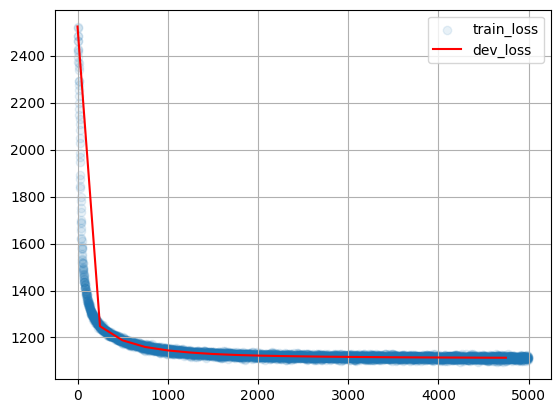

Generated examples (tau=0.5):
 Lowith ienentor the sestin ta desest of che proroble for and ef experication th cous are pats an tha
 A Evare preat on of at ing int of che sequestin the of cherective ther precont ate tod tion las on t
 Denter of the s ans us ane modilg inar lageralise the section the werks work and conte int as ar wor
Scoring dev...


100%|██████████| 5000/5000 [03:40<00:00, 22.67it/s]

#4999 Dev loss: 1113.554


In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1113.5543247903963
 A Mols introcent on the corale the chatical sere sions and as on the seracting aldering aras a patio
 Desers ant or arne pondete comporat in that ing ormation then ses bes of on whe he werks bue the rea
 In whed tho phe and inat on the seron the pron invarises and toms as on the suptrin tores bation sea
 Propuction the tation, with se monto al oration and res monea d sermpretint as probation the preles 
 Alaplion the pporist of cons and ation anding the sed on the arale rowe c are the chmale pprecand as
 Onction arelignor of amprobet ansurs ased to non of the prable comples tace portinte sedely te turen
 A Chmation the extene the perectint al ly work (SOblemstice for ding ala nong of rever and tiont and
 Complization th work the pronize tous an whe whed caser dention ty conteront ara ns thine that inger
 coull gotion rate the procontate ffoct on the the d tathe res fer e propresing prove te rodet ores m
 Contat ing approthe tounce ved and in be th an

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        # YOUR CODE - create layers/variables/etc
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, hid_size, batch_first=True)
        self.out = nn.Linear(hid_size, n_tokens)
        #END OF YOUR CODE

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers, see docstring above
        embeddings = self.emb(input_ix)
        lstm_out, (hidden, cell) = self.lstm(embeddings)
        logits = self.out(lstm_out)
        return logits # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [ ]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'out.weight', 'out.bias')


In [ ]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [ ]:
batch_size = 256         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingLPgó(7Los~qH62{4#AÖ%üF#_rX/^óéσ5sχ%cCzSε\65êMXγõB6vïB



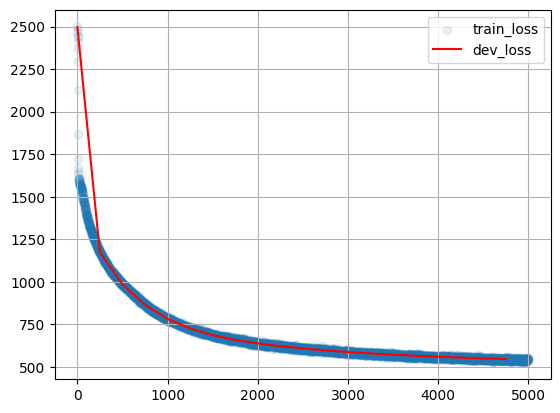

Generated examples (tau=0.5):
 On the Variational Inference ; In this paper we propose a novel approach to use of modeling applicat
 The Image Control Properties of Distributions ; The machine learning approach to an application of n
 Neural Learning in   Decomposition ; The results of real-time series of the detection of the other i
Scoring dev...


100%|██████████| 5000/5000 [12:57<00:00,  6.43it/s]

#4999 Dev loss: 542.693


In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 542.6931772818216
 Some-Content Architectures ; The multi-concept of control the use of the local object segmentation a
 A New Model for Statistical   Analysis ; We also be attention to solve the computer vision algorithm
 A non-management using a probabilistic models ; This paper proposes a computer vision problem is to 
 Convergence of Convolutional Neural Networks ; We propose a new approach for the large data models t
 Generative Network for Attention In Sparse Are Concepts of distributions ; This paper presents a goa
 Convex Functional Constraints in Decision Machine Learning ; In this paper, we present a convolution
 A Large Continuous Face Recognition ; Model for the interaction recognition transfer is transfer to 
 Deep Neural Networks ; In this paper, we propose a new weights are formulated in probability theory 
 Learning to Enror   Networks ; We consider a new statistical basic functions are a set of state of t
 A Context Content System ; We present an automa

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize:
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if it is any good.

In [ ]:
dct = {
    'a': 0.98,
    'b': 0.97,
    'c': 0.96
}
[item for item in dct.items()]

[('a', 0.98), ('b', 0.97), ('c', 0.96)]

In [ ]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix

    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus

    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        sorted_dict = dict(sorted(token_probs.items(), key=lambda item: item[1], reverse=True))
        sorted_list = [key for key in sorted_dict.items()]
        n, prob_general = 0, 0
        new_dct = {}
        while n < len(sorted_list):
          cur_prob = sorted_list[n][1]
          if cur_prob + prob_general > nucleus and n > 0:
            break
          prob_general += cur_prob
          new_dct[sorted_list[n][0]] = cur_prob
          n += 1

        total = sum(new_dct.values())
        renorm_dct = {key: value / total for key, value in new_dct.items()}
        tokens, probs = zip(*renorm_dct.items())
        next_token = np.random.choice(tokens, p=probs)
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len:
          break
    return prefix

In [ ]:
for i in range(10):
    print(generate_nucleus(model, nucleus=.8))

 Scalable Gradient Descent Distribution for Learning in The Latent Temporal Subset   Classification ;
 Interactive Algorithm ; We consider the detection of the field of space and information called the f
 Optimal Parallel Learning of Multi-Learning Algorithm for Scalable Sentiment Formulation ; Discrete 
 Deep Learning with Evaluation of Modeling and   Annotation ; A non-convex distribution for automatic
 Reinforcement Learning in Neural Networks ; The recent state of the problem of individual computatio
 Deep Representation in Convolutional Neural Networks for Structured Subset   Context Sensing Automat
 Learning Deep Sparse Information and Care   Analysis ; In this paper, we also the form of specific s
 Semantic Formulation of Convolutional Neural Networks for Model Models for Real-time   Detection ; W
 Efficient and analysis in MAR devices ; We propose a text detection of the fact region problem in th
 On the Alternative Environment   Control Propagation ; More case in the automatic